# Week 1-5 Research — Long-Run Optimizer Study (SGD vs Adam) on CNN/ResNet

This notebook runs longer experiments comparing SGD vs Adam/AdamW on TinyCNN and TinyResNet using larger datasets and more epochs. It saves inline plots and exports high-res images for Notion.

Goals for weeks 1-5:
- Longer runs (30–60 epochs) to observe convergence and stability
- Larger datasets (synthetic heavy-tailed; optional CIFAR/TinyImageNet if available)
- Compare SGD+Momentum vs AdamW
- Export plots to `reports/scaling_validation_v3/week1-5_plots/`

Tip: Use the FAST_RUN toggle to scale down for quick iteration.



In [ ]:
import math
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Fast iteration switch
FAST_RUN = False  # set True to shrink epochs/dataset while prototyping

# Reproducibility
SEED = 2025
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Output dirs
OUTPUT_DIR = Path("reports/scaling_validation_v3")
PLOT_DIR = OUTPUT_DIR / "week1-5_plots"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid", palette="tab10", context="talk")
plt.rcParams["figure.dpi"] = 120


Using device: cpu


In [2]:
# --- Heavy-tail utils and synthetic image builders ---

def zipf_probs(num_classes: int, s: float = 1.0) -> np.ndarray:
	indices = np.arange(1, num_classes + 1, dtype=np.float64)
	unnorm = 1.0 / np.power(indices, s)
	probs = unnorm / unnorm.sum()
	return probs


def make_heavy_tailed_labels(n: int, c: int, s: float = 1.0, min_per_class: int = 1) -> np.ndarray:
	pi = zipf_probs(c, s)
	labels: List[int] = []
	reserve = min_per_class * c
	if reserve <= n:
		for k in range(c):
			labels.extend([k] * min_per_class)
		remaining = n - reserve
		if remaining > 0:
			labels.extend(np.random.choice(c, size=remaining, p=pi))
	else:
		labels = list(np.random.choice(c, size=n, p=pi))
	labels_arr = np.array(labels, dtype=np.int64)
	np.random.shuffle(labels_arr)
	return labels_arr


def frequency_groups(y: np.ndarray, c: Optional[int] = None, n_groups: int = 10) -> List[np.ndarray]:
	if c is None:
		c = int(y.max()) + 1
	counts = np.bincount(y, minlength=c)
	order = np.argsort(-counts)
	cum = counts[order].cumsum()
	total = counts.sum()
	groups: List[np.ndarray] = []
	target = total / n_groups
	start = 0
	for g in range(n_groups - 1):
		end = np.searchsorted(cum, (g + 1) * target)
		groups.append(order[start:end])
		start = end
	groups.append(order[start:])
	return groups


class SimpleImageDataset(Dataset):
	def __init__(self, images: List[np.ndarray], labels: List[int]):
		self.X = torch.from_numpy(np.stack(images)).unsqueeze(1).float()
		self.y = torch.from_numpy(np.array(labels, dtype=np.int64))
	def __len__(self) -> int:
		return self.X.shape[0]
	def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
		return self.X[idx], self.y[idx]


def make_synthetic_image(cls: int, H: int = 32, W: int = 32, rng: Optional[np.random.RandomState] = None) -> np.ndarray:
	if rng is None:
		rng = np.random.RandomState(0)
	img = rng.rand(H, W) * 0.1
	k = cls % 10
	if k == 0:
		img[:H // 3, :W // 3] += 1.0
	elif k == 1:
		img[-H // 3 :, : W // 3] += 1.0
	elif k == 2:
		img[: H // 3, -W // 3 :] += 1.0
	elif k == 3:
		img[-H // 3 :, -W // 3 :] += 1.0
	elif k == 4:
		img[:, :2] += 1.0
	elif k == 5:
		img[:, -2:] += 1.0
	elif k == 6:
		img[:2, :] += 1.0
	elif k == 7:
		img[-2:, :] += 1.0
	elif k == 8:
		img[H // 2 - 2 : H // 2 + 2, :] += 1.0
	elif k == 9:
		img[:, W // 2 - 2 : W // 2 + 2] += 1.0
	return np.clip(img, 0.0, 1.0).astype(np.float32)


def build_synthetic_dataset(total_samples: int, num_classes: int, heavy: bool = True, seed: int = 0) -> SimpleImageDataset:
	rng = np.random.RandomState(seed)
	if heavy:
		y = make_heavy_tailed_labels(total_samples, num_classes, s=1.0, min_per_class=1)
	else:
		per = total_samples // num_classes
		y = np.concatenate([np.full(per, k, dtype=np.int64) for k in range(num_classes)])
		extra = total_samples - len(y)
		if extra > 0:
			y = np.concatenate([y, np.zeros(extra, dtype=np.int64)])
	images: List[np.ndarray] = []
	labels: List[int] = []
	for cls in y:
		images.append(make_synthetic_image(int(cls), H=32, W=32, rng=rng))
		labels.append(int(cls))
	return SimpleImageDataset(images, labels)

# Optional: torchvision datasets if available (CIFAR/TinyImageNet)
USE_TORCHVISION = False
try:
	import torchvision
	from torchvision import transforms
	USE_TORCHVISION = True
	print("torchvision available — CIFAR10/TinyImageNet option enabled")
except Exception:
	print("torchvision not available — using synthetic datasets")


def build_cifar10_dataset(limit: Optional[int] = None) -> Optional[Dataset]:
	if not USE_TORCHVISION:
		return None
	transform = transforms.Compose([
		transforms.Grayscale(num_output_channels=1),
		transforms.Resize((32, 32)),
		transforms.ToTensor(),
	])
	try:
		train = torchvision.datasets.CIFAR10(root=str(OUTPUT_DIR / "data"), train=True, download=True, transform=transform)
		test = torchvision.datasets.CIFAR10(root=str(OUTPUT_DIR / "data"), train=False, download=True, transform=transform)
		from torch.utils.data import ConcatDataset, Subset
		full = ConcatDataset([train, test])
		if limit is not None:
			idx = np.random.choice(len(full), size=min(limit, len(full)), replace=False)
			full = Subset(full, idx)
		return full
	except Exception as exc:
		print("CIFAR10 load failed:", exc)
		return None


torchvision available — CIFAR10/TinyImageNet option enabled


In [3]:
# --- Models: TinyCNN and TinyResNet ---

class TinyCNN(nn.Module):
	def __init__(self, num_classes: int):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(p=0.1)
		self.fc = nn.Linear(64 * 8 * 8, num_classes)  # for 32x32 inputs
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.dropout(x)
		x = torch.flatten(x, 1)
		return self.fc(x)


class ResidualBlock(nn.Module):
	def __init__(self, channels: int):
		super().__init__()
		self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(channels)
		self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
		self.bn2 = nn.BatchNorm2d(channels)
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		identity = x
		out = F.relu(self.bn1(self.conv1(x)))
		out = self.bn2(self.conv2(out))
		out = F.relu(out + identity)
		return out


class TinyResNet(nn.Module):
	def __init__(self, num_classes: int):
		super().__init__()
		self.stem = nn.Sequential(
			nn.Conv2d(1, 32, 3, padding=1, bias=False),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2, 2),
		)
		self.block1 = ResidualBlock(32)
		self.block2 = ResidualBlock(32)
		self.dropout = nn.Dropout(p=0.1)
		self.head = nn.Sequential(
			nn.AdaptiveAvgPool2d((1, 1)),
			nn.Flatten(),
			nn.Linear(32, num_classes),
		)
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.stem(x)
		x = self.block1(x)
		x = self.block2(x)
		x = self.dropout(x)
		return self.head(x)



In [4]:
# --- Training / evaluation utilities ---

def cross_entropy_with_label_smoothing(logits: torch.Tensor, targets: torch.Tensor, smoothing: float = 0.0) -> torch.Tensor:
	if smoothing <= 0.0:
		return F.cross_entropy(logits, targets)
	num_classes = logits.size(1)
	log_probs = F.log_softmax(logits, dim=1)
	targets_one_hot = F.one_hot(targets, num_classes=num_classes).float()
	targets_smoothed = targets_one_hot * (1 - smoothing) + smoothing / num_classes
	return (-targets_smoothed * log_probs).sum(dim=1).mean()


def make_optimizer(model: nn.Module, name: str, lr: float, weight_decay: float = 0.0) -> torch.optim.Optimizer:
	lname = name.lower()
	if lname in {"adam", "adamw"}:
		return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
	if lname in {"sgd", "sgd+momentum", "sgdm"}:
		return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
	raise ValueError(f"Unknown optimizer: {name}")


def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, smoothing: float = 0.0) -> Tuple[float, float]:
	model.train()
	total_loss = 0.0
	total_correct = 0
	total_seen = 0
	for xb, yb in loader:
		xb = xb.to(device)
		yb = yb.to(device)
		optimizer.zero_grad()
		logits = model(xb)
		loss = cross_entropy_with_label_smoothing(logits, yb, smoothing=smoothing)
		loss.backward()
		optimizer.step()
		total_loss += loss.item() * xb.size(0)
		preds = logits.argmax(dim=1)
		total_correct += (preds == yb).sum().item()
		total_seen += xb.size(0)
	return total_loss / total_seen, total_correct / total_seen


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, smoothing: float = 0.0) -> Dict[str, float]:
	model.eval()
	total_loss = 0.0
	total_correct = 0
	total_seen = 0
	for xb, yb in loader:
		xb = xb.to(device)
		yb = yb.to(device)
		logits = model(xb)
		loss = cross_entropy_with_label_smoothing(logits, yb, smoothing=smoothing)
		total_loss += loss.item() * xb.size(0)
		preds = logits.argmax(dim=1)
		total_correct += (preds == yb).sum().item()
		total_seen += xb.size(0)
	return {"loss": total_loss / total_seen, "accuracy": total_correct / total_seen}


def prepare_loaders(dataset: Dataset, batch_size: int = 256, val_ratio: float = 0.2, test_ratio: float = 0.1, seed: int = SEED) -> Tuple[DataLoader, DataLoader, DataLoader]:
	n_total = len(dataset)
	n_val = int(n_total * val_ratio)
	n_test = int(n_total * test_ratio)
	n_train = n_total - n_val - n_test
	assert n_train > 0, "Dataset too small for splits"
	lengths = [n_train, n_val, n_test]
	train_ds, val_ds, test_ds = random_split(dataset, lengths, generator=torch.Generator().manual_seed(seed))
	train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
	test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
	return train_loader, val_loader, test_loader



In [5]:
# --- Configure experiments (longer runs) ---

# Dataset config
if FAST_RUN:
	total_samples = 4000
	num_classes = 60
	batch_size = 128
	max_epochs = 12
else:
	total_samples = 20000
	num_classes = 120
	batch_size = 256
	max_epochs = 36  # extend to 50–60 on GPU if desired

use_heavy_tail = True  # toggle to compare balanced vs heavy-tailed

# Build dataset (prefer CIFAR10 if available, else synthetic heavy-tailed)
base_dataset = None
if USE_TORCHVISION:
	cifar = build_cifar10_dataset(limit=None if not FAST_RUN else 8000)
	if cifar is not None:
		base_dataset = cifar

if base_dataset is None:
	print("Building synthetic dataset...")
	base_dataset = build_synthetic_dataset(
		total_samples=total_samples,
		num_classes=num_classes,
		heavy=use_heavy_tail,
		seed=SEED,
	)

train_loader, val_loader, test_loader = prepare_loaders(base_dataset, batch_size=batch_size, seed=SEED)

# Model/optimizer config
optimizers = [
	{"name": "SGD+Momentum", "lr": 5e-3},
	{"name": "AdamW", "lr": 1e-3},
]
models = [
	("TinyCNN", TinyCNN),
	("TinyResNet", TinyResNet),
]

label_smoothing = 0.0
weight_decay = 5e-4 if not FAST_RUN else 0.0

print({
	"samples": len(base_dataset),
	"batch_size": batch_size,
	"classes": (int(base_dataset.y.max()) + 1) if hasattr(base_dataset, "y") else "CIFAR10",
	"epochs": max_epochs,
	"optimizers": [o["name"] for o in optimizers],
	"models": [m[0] for m in models],
})


100%|██████████| 170M/170M [00:06<00:00, 24.5MB/s] 


{'samples': 60000, 'batch_size': 256, 'classes': 'CIFAR10', 'epochs': 36, 'optimizers': ['SGD+Momentum', 'AdamW'], 'models': ['TinyCNN', 'TinyResNet']}


In [ ]:
# --- Run experiments ---

History = Dict[str, List[Dict[str, Any]]]
histories: History = {}
final_rows: List[Dict[str, Any]] = []

for model_name, model_ctor in models:
	for opt_cfg in optimizers:
		config_id = f"{model_name}|{opt_cfg['name']}|epochs={max_epochs}"
		print(f"Running {config_id} ...")
		model = model_ctor(num_classes=(int(base_dataset.y.max()) + 1) if hasattr(base_dataset, "y") else 10).to(device)
		optimizer = make_optimizer(model, opt_cfg["name"], lr=opt_cfg["lr"], weight_decay=weight_decay)
		train_hist: List[Dict[str, Any]] = []
		for ep in range(1, max_epochs + 1):
			loss_tr, acc_tr = train_epoch(model, train_loader, optimizer, smoothing=label_smoothing)
			val_metrics = evaluate(model, val_loader, smoothing=label_smoothing)
			train_hist.append({
				"epoch": ep,
				"train_loss": loss_tr,
				"train_acc": acc_tr,
				"val_loss": val_metrics["loss"],
				"val_acc": val_metrics["accuracy"],
			})
		print(f"  -> last epoch: train_loss={train_hist[-1]['train_loss']:.3f} val_acc={train_hist[-1]['val_acc']:.3f}")
		# Final test
		test_metrics = evaluate(model, test_loader, smoothing=label_smoothing)
		histories[config_id] = train_hist
		final_rows.append({
			"config_id": config_id,
			"model": model_name,
			"optimizer": opt_cfg["name"],
			"epochs": max_epochs,
			"val_accuracy": train_hist[-1]["val_acc"],
			"val_loss": train_hist[-1]["val_loss"],
			"test_accuracy": test_metrics["accuracy"],
			"test_loss": test_metrics["loss"],
		})

results_df = pd.DataFrame(final_rows)
results_csv = OUTPUT_DIR / "week1-5_long_run_summaries.csv"
results_df.to_csv(results_csv, index=False)
print(f"Saved: {results_csv}")


/Users/prashantpotluri/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running TinyCNN|SGD+Momentum|epochs=36 ...


TinyCNN|SGD+Momentum|epochs=36:   3%|▎         | 1/36 [00:30<17:54, 30.71s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 001/36 | train_loss=2.177 | val_acc=0.283


TinyCNN|SGD+Momentum|epochs=36:   6%|▌         | 2/36 [00:53<14:40, 25.90s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 002/36 | train_loss=1.980 | val_acc=0.347


TinyCNN|SGD+Momentum|epochs=36:   8%|▊         | 3/36 [01:15<13:19, 24.21s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 003/36 | train_loss=1.805 | val_acc=0.356


TinyCNN|SGD+Momentum|epochs=36:  11%|█         | 4/36 [01:37<12:28, 23.40s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 004/36 | train_loss=1.693 | val_acc=0.412


TinyCNN|SGD+Momentum|epochs=36:  14%|█▍        | 5/36 [01:59<11:52, 22.97s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 005/36 | train_loss=1.608 | val_acc=0.439


TinyCNN|SGD+Momentum|epochs=36:  17%|█▋        | 6/36 [02:22<11:21, 22.71s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 006/36 | train_loss=1.554 | val_acc=0.446


TinyCNN|SGD+Momentum|epochs=36:  19%|█▉        | 7/36 [02:44<10:53, 22.53s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 007/36 | train_loss=1.501 | val_acc=0.473


TinyCNN|SGD+Momentum|epochs=36:  22%|██▏       | 8/36 [03:06<10:26, 22.36s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 008/36 | train_loss=1.463 | val_acc=0.472


TinyCNN|SGD+Momentum|epochs=36:  25%|██▌       | 9/36 [03:28<10:04, 22.40s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 009/36 | train_loss=1.438 | val_acc=0.480


TinyCNN|SGD+Momentum|epochs=36:  28%|██▊       | 10/36 [03:50<09:41, 22.35s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 010/36 | train_loss=1.399 | val_acc=0.496


TinyCNN|SGD+Momentum|epochs=36:  31%|███       | 11/36 [04:12<09:16, 22.27s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 011/36 | train_loss=1.370 | val_acc=0.490


TinyCNN|SGD+Momentum|epochs=36:  33%|███▎      | 12/36 [04:35<08:53, 22.21s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 012/36 | train_loss=1.339 | val_acc=0.524


TinyCNN|SGD+Momentum|epochs=36:  36%|███▌      | 13/36 [04:57<08:30, 22.19s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 013/36 | train_loss=1.305 | val_acc=0.538


TinyCNN|SGD+Momentum|epochs=36:  39%|███▉      | 14/36 [05:20<08:17, 22.63s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 014/36 | train_loss=1.285 | val_acc=0.551


TinyCNN|SGD+Momentum|epochs=36:  42%|████▏     | 15/36 [05:42<07:51, 22.44s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 015/36 | train_loss=1.261 | val_acc=0.557


TinyCNN|SGD+Momentum|epochs=36:  44%|████▍     | 16/36 [06:05<07:27, 22.39s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 016/36 | train_loss=1.241 | val_acc=0.566


TinyCNN|SGD+Momentum|epochs=36:  47%|████▋     | 17/36 [06:27<07:07, 22.48s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 017/36 | train_loss=1.221 | val_acc=0.562


TinyCNN|SGD+Momentum|epochs=36:  50%|█████     | 18/36 [06:49<06:42, 22.38s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 018/36 | train_loss=1.208 | val_acc=0.565


TinyCNN|SGD+Momentum|epochs=36:  53%|█████▎    | 19/36 [07:12<06:18, 22.28s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 019/36 | train_loss=1.192 | val_acc=0.576


TinyCNN|SGD+Momentum|epochs=36:  56%|█████▌    | 20/36 [07:34<05:55, 22.21s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 020/36 | train_loss=1.176 | val_acc=0.563


TinyCNN|SGD+Momentum|epochs=36:  58%|█████▊    | 21/36 [07:56<05:32, 22.20s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 021/36 | train_loss=1.160 | val_acc=0.584


TinyCNN|SGD+Momentum|epochs=36:  61%|██████    | 22/36 [08:18<05:11, 22.26s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 022/36 | train_loss=1.142 | val_acc=0.589


TinyCNN|SGD+Momentum|epochs=36:  64%|██████▍   | 23/36 [08:41<04:52, 22.47s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 023/36 | train_loss=1.127 | val_acc=0.597


TinyCNN|SGD+Momentum|epochs=36:  67%|██████▋   | 24/36 [09:03<04:26, 22.22s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 024/36 | train_loss=1.118 | val_acc=0.598


TinyCNN|SGD+Momentum|epochs=36:  69%|██████▉   | 25/36 [09:26<04:06, 22.44s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 025/36 | train_loss=1.106 | val_acc=0.603


TinyCNN|SGD+Momentum|epochs=36:  72%|███████▏  | 26/36 [09:48<03:43, 22.32s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 026/36 | train_loss=1.096 | val_acc=0.588


TinyCNN|SGD+Momentum|epochs=36:  75%|███████▌  | 27/36 [10:12<03:26, 22.93s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 027/36 | train_loss=1.088 | val_acc=0.609


TinyCNN|SGD+Momentum|epochs=36:  78%|███████▊  | 28/36 [10:34<03:01, 22.75s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 028/36 | train_loss=1.076 | val_acc=0.580


TinyCNN|SGD+Momentum|epochs=36:  81%|████████  | 29/36 [10:57<02:38, 22.61s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 029/36 | train_loss=1.063 | val_acc=0.605


TinyCNN|SGD+Momentum|epochs=36:  83%|████████▎ | 30/36 [11:19<02:15, 22.59s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 030/36 | train_loss=1.053 | val_acc=0.583


TinyCNN|SGD+Momentum|epochs=36:  86%|████████▌ | 31/36 [11:41<01:52, 22.48s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 031/36 | train_loss=1.047 | val_acc=0.626


TinyCNN|SGD+Momentum|epochs=36:  89%|████████▉ | 32/36 [12:04<01:29, 22.37s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 032/36 | train_loss=1.036 | val_acc=0.626


TinyCNN|SGD+Momentum|epochs=36:  92%|█████████▏| 33/36 [12:26<01:07, 22.35s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 033/36 | train_loss=1.029 | val_acc=0.596


TinyCNN|SGD+Momentum|epochs=36:  94%|█████████▍| 34/36 [12:48<00:44, 22.24s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 034/36 | train_loss=1.014 | val_acc=0.606


TinyCNN|SGD+Momentum|epochs=36:  97%|█████████▋| 35/36 [13:10<00:22, 22.25s/it]

TinyCNN|SGD+Momentum|epochs=36 | epoch 035/36 | train_loss=1.014 | val_acc=0.616


TinyCNN|SGD+Momentum|epochs=36 | epoch 036/36 | train_loss=1.000 | val_acc=0.614
  -> last epoch: train_loss=1.000 val_acc=0.614
Running TinyCNN|AdamW|epochs=36 ...


TinyCNN|AdamW|epochs=36:   3%|▎         | 1/36 [00:21<12:48, 21.96s/it]

TinyCNN|AdamW|epochs=36 | epoch 001/36 | train_loss=1.861 | val_acc=0.425


TinyCNN|AdamW|epochs=36:   6%|▌         | 2/36 [00:44<12:47, 22.57s/it]

TinyCNN|AdamW|epochs=36 | epoch 002/36 | train_loss=1.532 | val_acc=0.490


TinyCNN|AdamW|epochs=36:   8%|▊         | 3/36 [01:07<12:20, 22.44s/it]

TinyCNN|AdamW|epochs=36 | epoch 003/36 | train_loss=1.394 | val_acc=0.528


TinyCNN|AdamW|epochs=36:  11%|█         | 4/36 [01:30<12:06, 22.69s/it]

TinyCNN|AdamW|epochs=36 | epoch 004/36 | train_loss=1.307 | val_acc=0.556


TinyCNN|AdamW|epochs=36:  14%|█▍        | 5/36 [01:53<11:47, 22.82s/it]

TinyCNN|AdamW|epochs=36 | epoch 005/36 | train_loss=1.238 | val_acc=0.572


TinyCNN|AdamW|epochs=36:  17%|█▋        | 6/36 [02:15<11:20, 22.69s/it]

TinyCNN|AdamW|epochs=36 | epoch 006/36 | train_loss=1.194 | val_acc=0.561


TinyCNN|AdamW|epochs=36:  19%|█▉        | 7/36 [02:38<10:55, 22.60s/it]

TinyCNN|AdamW|epochs=36 | epoch 007/36 | train_loss=1.159 | val_acc=0.594


TinyCNN|AdamW|epochs=36:  22%|██▏       | 8/36 [03:00<10:28, 22.45s/it]

TinyCNN|AdamW|epochs=36 | epoch 008/36 | train_loss=1.122 | val_acc=0.602


TinyCNN|AdamW|epochs=36:  25%|██▌       | 9/36 [03:22<10:03, 22.34s/it]

TinyCNN|AdamW|epochs=36 | epoch 009/36 | train_loss=1.096 | val_acc=0.594


TinyCNN|AdamW|epochs=36:  28%|██▊       | 10/36 [03:45<09:43, 22.43s/it]

TinyCNN|AdamW|epochs=36 | epoch 010/36 | train_loss=1.079 | val_acc=0.615


TinyCNN|AdamW|epochs=36:  31%|███       | 11/36 [04:07<09:18, 22.34s/it]

TinyCNN|AdamW|epochs=36 | epoch 011/36 | train_loss=1.057 | val_acc=0.617


TinyCNN|AdamW|epochs=36:  33%|███▎      | 12/36 [04:30<09:03, 22.64s/it]

TinyCNN|AdamW|epochs=36 | epoch 012/36 | train_loss=1.035 | val_acc=0.612


TinyCNN|AdamW|epochs=36:  36%|███▌      | 13/36 [04:52<08:39, 22.58s/it]

TinyCNN|AdamW|epochs=36 | epoch 013/36 | train_loss=1.022 | val_acc=0.614


TinyCNN|AdamW|epochs=36:  39%|███▉      | 14/36 [05:15<08:14, 22.46s/it]

TinyCNN|AdamW|epochs=36 | epoch 014/36 | train_loss=1.001 | val_acc=0.599


TinyCNN|AdamW|epochs=36:  42%|████▏     | 15/36 [05:37<07:49, 22.38s/it]

TinyCNN|AdamW|epochs=36 | epoch 015/36 | train_loss=0.999 | val_acc=0.626


TinyCNN|AdamW|epochs=36:  44%|████▍     | 16/36 [05:59<07:27, 22.36s/it]

TinyCNN|AdamW|epochs=36 | epoch 016/36 | train_loss=0.977 | val_acc=0.628


TinyCNN|AdamW|epochs=36:  47%|████▋     | 17/36 [06:21<07:03, 22.28s/it]

TinyCNN|AdamW|epochs=36 | epoch 017/36 | train_loss=0.966 | val_acc=0.630


TinyCNN|AdamW|epochs=36:  50%|█████     | 18/36 [06:46<06:55, 23.07s/it]

TinyCNN|AdamW|epochs=36 | epoch 018/36 | train_loss=0.953 | val_acc=0.638


TinyCNN|AdamW|epochs=36:  53%|█████▎    | 19/36 [07:09<06:30, 22.96s/it]

TinyCNN|AdamW|epochs=36 | epoch 019/36 | train_loss=0.939 | val_acc=0.634


TinyCNN|AdamW|epochs=36:  56%|█████▌    | 20/36 [07:33<06:10, 23.16s/it]

TinyCNN|AdamW|epochs=36 | epoch 020/36 | train_loss=0.937 | val_acc=0.634


TinyCNN|AdamW|epochs=36:  58%|█████▊    | 21/36 [07:57<05:51, 23.42s/it]

TinyCNN|AdamW|epochs=36 | epoch 021/36 | train_loss=0.919 | val_acc=0.644


TinyCNN|AdamW|epochs=36:  61%|██████    | 22/36 [08:20<05:27, 23.39s/it]

TinyCNN|AdamW|epochs=36 | epoch 022/36 | train_loss=0.904 | val_acc=0.642


TinyCNN|AdamW|epochs=36:  64%|██████▍   | 23/36 [08:46<05:14, 24.20s/it]

TinyCNN|AdamW|epochs=36 | epoch 023/36 | train_loss=0.899 | val_acc=0.643


TinyCNN|AdamW|epochs=36:  67%|██████▋   | 24/36 [09:08<04:43, 23.59s/it]

TinyCNN|AdamW|epochs=36 | epoch 024/36 | train_loss=0.886 | val_acc=0.641


TinyCNN|AdamW|epochs=36:  69%|██████▉   | 25/36 [09:31<04:17, 23.39s/it]

TinyCNN|AdamW|epochs=36 | epoch 025/36 | train_loss=0.881 | val_acc=0.638


TinyCNN|AdamW|epochs=36:  72%|███████▏  | 26/36 [09:54<03:51, 23.19s/it]

TinyCNN|AdamW|epochs=36 | epoch 026/36 | train_loss=0.872 | val_acc=0.647


TinyCNN|AdamW|epochs=36:  75%|███████▌  | 27/36 [10:16<03:26, 23.00s/it]

TinyCNN|AdamW|epochs=36 | epoch 027/36 | train_loss=0.866 | val_acc=0.644


TinyCNN|AdamW|epochs=36:  78%|███████▊  | 28/36 [10:39<03:03, 22.91s/it]

TinyCNN|AdamW|epochs=36 | epoch 028/36 | train_loss=0.857 | val_acc=0.645


TinyCNN|AdamW|epochs=36:  81%|████████  | 29/36 [11:02<02:39, 22.80s/it]

TinyCNN|AdamW|epochs=36 | epoch 029/36 | train_loss=0.845 | val_acc=0.640


TinyCNN|AdamW|epochs=36:  83%|████████▎ | 30/36 [11:24<02:17, 22.84s/it]

TinyCNN|AdamW|epochs=36 | epoch 030/36 | train_loss=0.841 | val_acc=0.653


TinyCNN|AdamW|epochs=36:  86%|████████▌ | 31/36 [11:51<01:59, 23.81s/it]

TinyCNN|AdamW|epochs=36 | epoch 031/36 | train_loss=0.837 | val_acc=0.646


TinyCNN|AdamW|epochs=36:  89%|████████▉ | 32/36 [12:13<01:34, 23.55s/it]

TinyCNN|AdamW|epochs=36 | epoch 032/36 | train_loss=0.822 | val_acc=0.657


TinyCNN|AdamW|epochs=36:  92%|█████████▏| 33/36 [12:37<01:10, 23.46s/it]

TinyCNN|AdamW|epochs=36 | epoch 033/36 | train_loss=0.818 | val_acc=0.652


TinyCNN|AdamW|epochs=36:  94%|█████████▍| 34/36 [13:00<00:46, 23.27s/it]

TinyCNN|AdamW|epochs=36 | epoch 034/36 | train_loss=0.812 | val_acc=0.648


TinyCNN|AdamW|epochs=36:  97%|█████████▋| 35/36 [13:22<00:23, 23.11s/it]

TinyCNN|AdamW|epochs=36 | epoch 035/36 | train_loss=0.808 | val_acc=0.656


TinyCNN|AdamW|epochs=36 | epoch 036/36 | train_loss=0.793 | val_acc=0.656
  -> last epoch: train_loss=0.793 val_acc=0.656
Running TinyResNet|SGD+Momentum|epochs=36 ...


TinyResNet|SGD+Momentum|epochs=36:   3%|▎         | 1/36 [00:51<30:10, 51.74s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 001/36 | train_loss=1.966 | val_acc=0.354


TinyResNet|SGD+Momentum|epochs=36:   6%|▌         | 2/36 [01:47<30:39, 54.10s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 002/36 | train_loss=1.604 | val_acc=0.240


TinyResNet|SGD+Momentum|epochs=36:   8%|▊         | 3/36 [02:40<29:31, 53.69s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 003/36 | train_loss=1.459 | val_acc=0.402


TinyResNet|SGD+Momentum|epochs=36:  11%|█         | 4/36 [03:33<28:30, 53.44s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 004/36 | train_loss=1.353 | val_acc=0.317


TinyResNet|SGD+Momentum|epochs=36:  14%|█▍        | 5/36 [04:31<28:30, 55.17s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 005/36 | train_loss=1.272 | val_acc=0.424


TinyResNet|SGD+Momentum|epochs=36:  17%|█▋        | 6/36 [05:52<31:57, 63.92s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 006/36 | train_loss=1.212 | val_acc=0.385


TinyResNet|SGD+Momentum|epochs=36:  19%|█▉        | 7/36 [06:55<30:42, 63.53s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 007/36 | train_loss=1.164 | val_acc=0.465


TinyResNet|SGD+Momentum|epochs=36:  22%|██▏       | 8/36 [07:49<28:10, 60.39s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 008/36 | train_loss=1.117 | val_acc=0.524


TinyResNet|SGD+Momentum|epochs=36:  25%|██▌       | 9/36 [08:40<25:51, 57.47s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 009/36 | train_loss=1.073 | val_acc=0.364


TinyResNet|SGD+Momentum|epochs=36:  28%|██▊       | 10/36 [09:30<23:56, 55.27s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 010/36 | train_loss=1.039 | val_acc=0.500


TinyResNet|SGD+Momentum|epochs=36:  31%|███       | 11/36 [10:31<23:46, 57.04s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 011/36 | train_loss=1.009 | val_acc=0.323


TinyResNet|SGD+Momentum|epochs=36:  33%|███▎      | 12/36 [11:32<23:14, 58.09s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 012/36 | train_loss=0.988 | val_acc=0.545


TinyResNet|SGD+Momentum|epochs=36:  36%|███▌      | 13/36 [12:30<22:14, 58.01s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 013/36 | train_loss=0.956 | val_acc=0.319


TinyResNet|SGD+Momentum|epochs=36:  39%|███▉      | 14/36 [13:23<20:45, 56.60s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 014/36 | train_loss=0.935 | val_acc=0.459


TinyResNet|SGD+Momentum|epochs=36:  42%|████▏     | 15/36 [14:19<19:47, 56.54s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 015/36 | train_loss=0.927 | val_acc=0.350


TinyResNet|SGD+Momentum|epochs=36:  44%|████▍     | 16/36 [15:13<18:35, 55.77s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 016/36 | train_loss=0.895 | val_acc=0.543


TinyResNet|SGD+Momentum|epochs=36:  47%|████▋     | 17/36 [16:20<18:41, 59.03s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 017/36 | train_loss=0.868 | val_acc=0.295


TinyResNet|SGD+Momentum|epochs=36:  50%|█████     | 18/36 [17:33<18:56, 63.12s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 018/36 | train_loss=0.865 | val_acc=0.365


TinyResNet|SGD+Momentum|epochs=36:  53%|█████▎    | 19/36 [18:30<17:22, 61.34s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 019/36 | train_loss=0.832 | val_acc=0.566


TinyResNet|SGD+Momentum|epochs=36:  56%|█████▌    | 20/36 [19:22<15:39, 58.73s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 020/36 | train_loss=0.821 | val_acc=0.624


TinyResNet|SGD+Momentum|epochs=36:  58%|█████▊    | 21/36 [20:21<14:42, 58.82s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 021/36 | train_loss=0.806 | val_acc=0.370


TinyResNet|SGD+Momentum|epochs=36:  61%|██████    | 22/36 [21:22<13:52, 59.46s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 022/36 | train_loss=0.791 | val_acc=0.383


TinyResNet|SGD+Momentum|epochs=36:  64%|██████▍   | 23/36 [22:25<13:04, 60.37s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 023/36 | train_loss=0.781 | val_acc=0.547


TinyResNet|SGD+Momentum|epochs=36:  67%|██████▋   | 24/36 [23:27<12:10, 60.87s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 024/36 | train_loss=0.756 | val_acc=0.323


TinyResNet|SGD+Momentum|epochs=36:  69%|██████▉   | 25/36 [24:42<11:57, 65.18s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 025/36 | train_loss=0.748 | val_acc=0.528


TinyResNet|SGD+Momentum|epochs=36:  72%|███████▏  | 26/36 [26:22<12:35, 75.52s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 026/36 | train_loss=0.737 | val_acc=0.631


TinyResNet|SGD+Momentum|epochs=36:  75%|███████▌  | 27/36 [27:51<11:56, 79.66s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 027/36 | train_loss=0.722 | val_acc=0.622


TinyResNet|SGD+Momentum|epochs=36:  78%|███████▊  | 28/36 [29:03<10:18, 77.29s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 028/36 | train_loss=0.705 | val_acc=0.560


TinyResNet|SGD+Momentum|epochs=36:  81%|████████  | 29/36 [29:57<08:12, 70.35s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 029/36 | train_loss=0.701 | val_acc=0.591


TinyResNet|SGD+Momentum|epochs=36:  83%|████████▎ | 30/36 [30:52<06:33, 65.66s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 030/36 | train_loss=0.686 | val_acc=0.649


TinyResNet|SGD+Momentum|epochs=36:  86%|████████▌ | 31/36 [31:46<05:10, 62.14s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 031/36 | train_loss=0.675 | val_acc=0.603


TinyResNet|SGD+Momentum|epochs=36:  89%|████████▉ | 32/36 [32:39<03:58, 59.65s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 032/36 | train_loss=0.664 | val_acc=0.704


TinyResNet|SGD+Momentum|epochs=36:  92%|█████████▏| 33/36 [33:36<02:55, 58.59s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 033/36 | train_loss=0.653 | val_acc=0.500


TinyResNet|SGD+Momentum|epochs=36:  94%|█████████▍| 34/36 [34:31<01:55, 57.69s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 034/36 | train_loss=0.649 | val_acc=0.636


TinyResNet|SGD+Momentum|epochs=36:  97%|█████████▋| 35/36 [35:25<00:56, 56.48s/it]

TinyResNet|SGD+Momentum|epochs=36 | epoch 035/36 | train_loss=0.636 | val_acc=0.551


TinyResNet|SGD+Momentum|epochs=36 | epoch 036/36 | train_loss=0.632 | val_acc=0.465
  -> last epoch: train_loss=0.632 val_acc=0.465
Running TinyResNet|AdamW|epochs=36 ...


TinyResNet|AdamW|epochs=36:   3%|▎         | 1/36 [00:59<34:47, 59.65s/it]

TinyResNet|AdamW|epochs=36 | epoch 001/36 | train_loss=1.727 | val_acc=0.349


TinyResNet|AdamW|epochs=36:   6%|▌         | 2/36 [01:51<31:14, 55.14s/it]

TinyResNet|AdamW|epochs=36 | epoch 002/36 | train_loss=1.365 | val_acc=0.430


TinyResNet|AdamW|epochs=36:   8%|▊         | 3/36 [02:42<29:19, 53.33s/it]

TinyResNet|AdamW|epochs=36 | epoch 003/36 | train_loss=1.221 | val_acc=0.496


TinyResNet|AdamW|epochs=36:  11%|█         | 4/36 [03:33<27:54, 52.34s/it]

TinyResNet|AdamW|epochs=36 | epoch 004/36 | train_loss=1.124 | val_acc=0.485


TinyResNet|AdamW|epochs=36:  14%|█▍        | 5/36 [04:24<26:48, 51.89s/it]

TinyResNet|AdamW|epochs=36 | epoch 005/36 | train_loss=1.055 | val_acc=0.567


TinyResNet|AdamW|epochs=36:  17%|█▋        | 6/36 [05:15<25:46, 51.57s/it]

TinyResNet|AdamW|epochs=36 | epoch 006/36 | train_loss=1.008 | val_acc=0.551


TinyResNet|AdamW|epochs=36:  19%|█▉        | 7/36 [06:07<24:56, 51.59s/it]

TinyResNet|AdamW|epochs=36 | epoch 007/36 | train_loss=0.962 | val_acc=0.367


TinyResNet|AdamW|epochs=36:  22%|██▏       | 8/36 [07:00<24:18, 52.08s/it]

TinyResNet|AdamW|epochs=36 | epoch 008/36 | train_loss=0.930 | val_acc=0.510


TinyResNet|AdamW|epochs=36:  25%|██▌       | 9/36 [07:51<23:20, 51.86s/it]

TinyResNet|AdamW|epochs=36 | epoch 009/36 | train_loss=0.893 | val_acc=0.564


TinyResNet|AdamW|epochs=36:  28%|██▊       | 10/36 [08:45<22:41, 52.35s/it]

TinyResNet|AdamW|epochs=36 | epoch 010/36 | train_loss=0.865 | val_acc=0.622


TinyResNet|AdamW|epochs=36:  31%|███       | 11/36 [09:37<21:50, 52.42s/it]

TinyResNet|AdamW|epochs=36 | epoch 011/36 | train_loss=0.834 | val_acc=0.479


TinyResNet|AdamW|epochs=36:  33%|███▎      | 12/36 [10:29<20:53, 52.25s/it]

TinyResNet|AdamW|epochs=36 | epoch 012/36 | train_loss=0.818 | val_acc=0.593


TinyResNet|AdamW|epochs=36:  36%|███▌      | 13/36 [14:16<40:18, 105.15s/it]

TinyResNet|AdamW|epochs=36 | epoch 013/36 | train_loss=0.789 | val_acc=0.607


TinyResNet|AdamW|epochs=36:  39%|███▉      | 14/36 [15:38<35:58, 98.11s/it] 

TinyResNet|AdamW|epochs=36 | epoch 014/36 | train_loss=0.774 | val_acc=0.625


TinyResNet|AdamW|epochs=36:  42%|████▏     | 15/36 [16:34<29:57, 85.58s/it]

TinyResNet|AdamW|epochs=36 | epoch 015/36 | train_loss=0.753 | val_acc=0.612


TinyResNet|AdamW|epochs=36:  44%|████▍     | 16/36 [17:28<25:21, 76.07s/it]

TinyResNet|AdamW|epochs=36 | epoch 016/36 | train_loss=0.733 | val_acc=0.634


TinyResNet|AdamW|epochs=36:  47%|████▋     | 17/36 [18:26<22:19, 70.52s/it]

TinyResNet|AdamW|epochs=36 | epoch 017/36 | train_loss=0.719 | val_acc=0.560


TinyResNet|AdamW|epochs=36:  50%|█████     | 18/36 [19:22<19:48, 66.04s/it]

TinyResNet|AdamW|epochs=36 | epoch 018/36 | train_loss=0.706 | val_acc=0.662


TinyResNet|AdamW|epochs=36:  53%|█████▎    | 19/36 [20:15<17:35, 62.09s/it]

TinyResNet|AdamW|epochs=36 | epoch 019/36 | train_loss=0.691 | val_acc=0.627


TinyResNet|AdamW|epochs=36:  56%|█████▌    | 20/36 [21:08<15:53, 59.61s/it]

TinyResNet|AdamW|epochs=36 | epoch 020/36 | train_loss=0.674 | val_acc=0.622


TinyResNet|AdamW|epochs=36:  58%|█████▊    | 21/36 [21:59<14:13, 56.87s/it]

TinyResNet|AdamW|epochs=36 | epoch 021/36 | train_loss=0.660 | val_acc=0.644


TinyResNet|AdamW|epochs=36:  61%|██████    | 22/36 [22:49<12:48, 54.92s/it]

TinyResNet|AdamW|epochs=36 | epoch 022/36 | train_loss=0.646 | val_acc=0.693


TinyResNet|AdamW|epochs=36:  64%|██████▍   | 23/36 [23:40<11:38, 53.70s/it]

TinyResNet|AdamW|epochs=36 | epoch 023/36 | train_loss=0.636 | val_acc=0.633


TinyResNet|AdamW|epochs=36:  67%|██████▋   | 24/36 [24:33<10:40, 53.35s/it]

TinyResNet|AdamW|epochs=36 | epoch 024/36 | train_loss=0.630 | val_acc=0.645


TinyResNet|AdamW|epochs=36:  69%|██████▉   | 25/36 [25:25<09:43, 53.02s/it]

TinyResNet|AdamW|epochs=36 | epoch 025/36 | train_loss=0.614 | val_acc=0.690


TinyResNet|AdamW|epochs=36:  72%|███████▏  | 26/36 [26:17<08:47, 52.76s/it]

TinyResNet|AdamW|epochs=36 | epoch 026/36 | train_loss=0.600 | val_acc=0.592


TinyResNet|AdamW|epochs=36:  75%|███████▌  | 27/36 [27:09<07:53, 52.57s/it]

TinyResNet|AdamW|epochs=36 | epoch 027/36 | train_loss=0.598 | val_acc=0.610


TinyResNet|AdamW|epochs=36:  78%|███████▊  | 28/36 [28:01<06:57, 52.24s/it]

TinyResNet|AdamW|epochs=36 | epoch 028/36 | train_loss=0.585 | val_acc=0.579


TinyResNet|AdamW|epochs=36:  81%|████████  | 29/36 [28:53<06:06, 52.40s/it]

TinyResNet|AdamW|epochs=36 | epoch 029/36 | train_loss=0.578 | val_acc=0.707


TinyResNet|AdamW|epochs=36:  83%|████████▎ | 30/36 [29:49<05:20, 53.43s/it]

TinyResNet|AdamW|epochs=36 | epoch 030/36 | train_loss=0.573 | val_acc=0.704


TinyResNet|AdamW|epochs=36:  86%|████████▌ | 31/36 [30:42<04:25, 53.15s/it]

TinyResNet|AdamW|epochs=36 | epoch 031/36 | train_loss=0.559 | val_acc=0.682


TinyResNet|AdamW|epochs=36:  89%|████████▉ | 32/36 [31:34<03:31, 52.75s/it]

TinyResNet|AdamW|epochs=36 | epoch 032/36 | train_loss=0.555 | val_acc=0.721


TinyResNet|AdamW|epochs=36:  92%|█████████▏| 33/36 [32:26<02:37, 52.61s/it]

TinyResNet|AdamW|epochs=36 | epoch 033/36 | train_loss=0.538 | val_acc=0.700


TinyResNet|AdamW|epochs=36:  94%|█████████▍| 34/36 [33:17<01:44, 52.30s/it]

TinyResNet|AdamW|epochs=36 | epoch 034/36 | train_loss=0.535 | val_acc=0.596


TinyResNet|AdamW|epochs=36:  97%|█████████▋| 35/36 [34:10<00:52, 52.27s/it]

TinyResNet|AdamW|epochs=36 | epoch 035/36 | train_loss=0.533 | val_acc=0.677


TinyResNet|AdamW|epochs=36 | epoch 036/36 | train_loss=0.525 | val_acc=0.629
  -> last epoch: train_loss=0.525 val_acc=0.629
Saved: reports/scaling_validation_v3/week5_long_run_summaries.csv


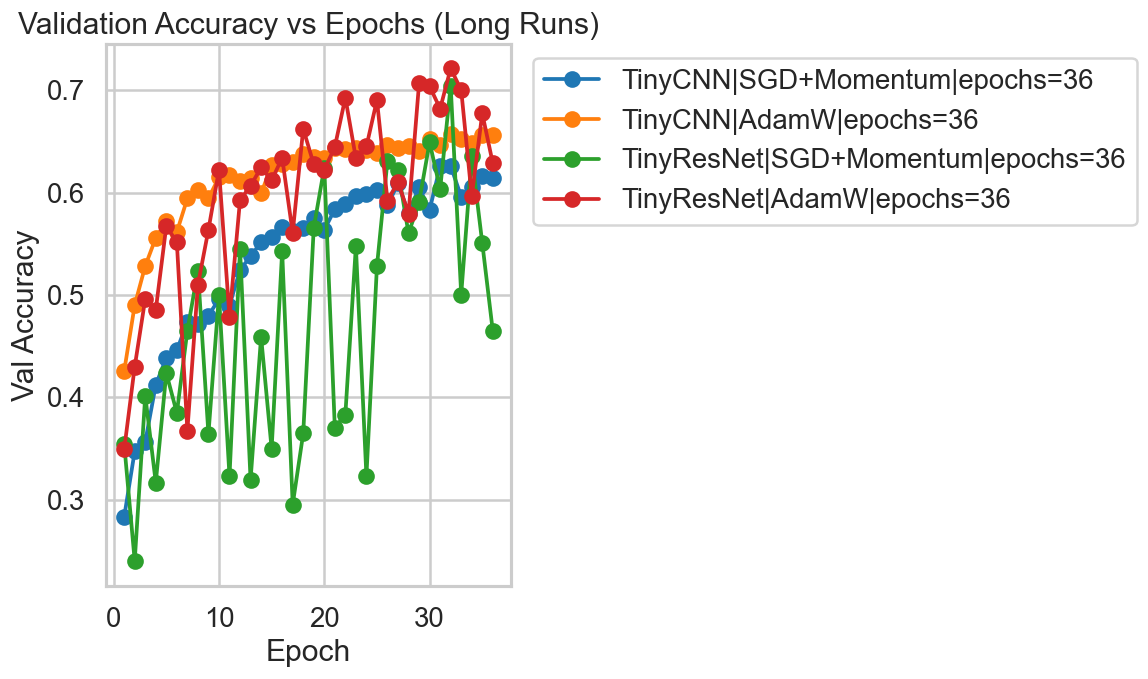

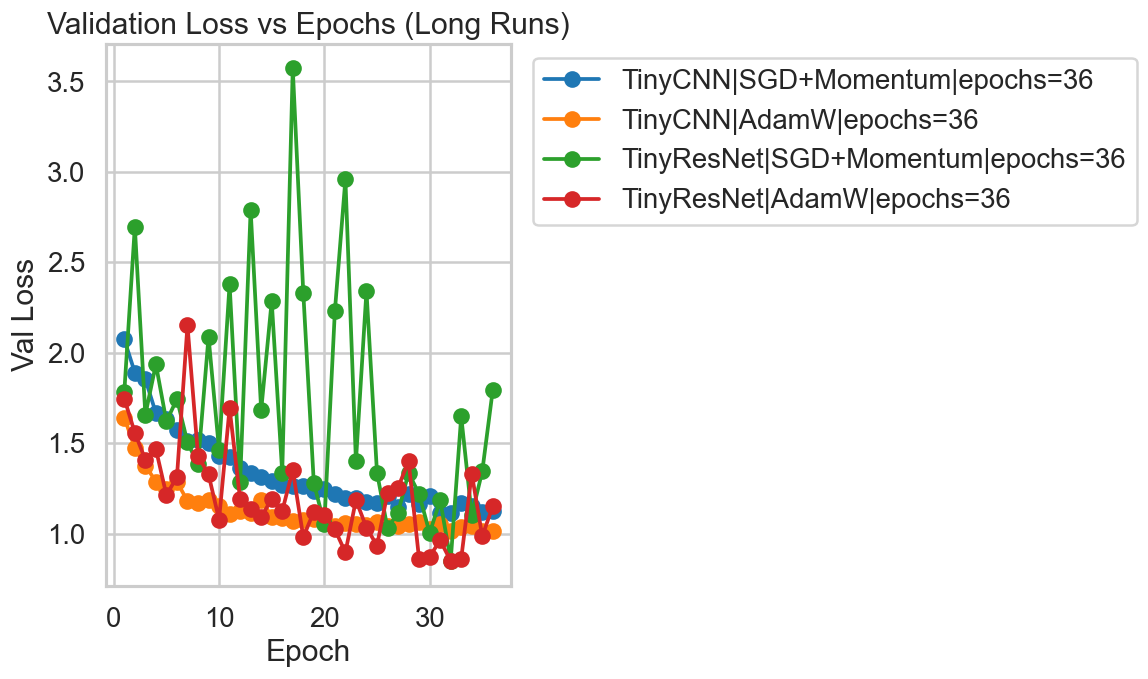

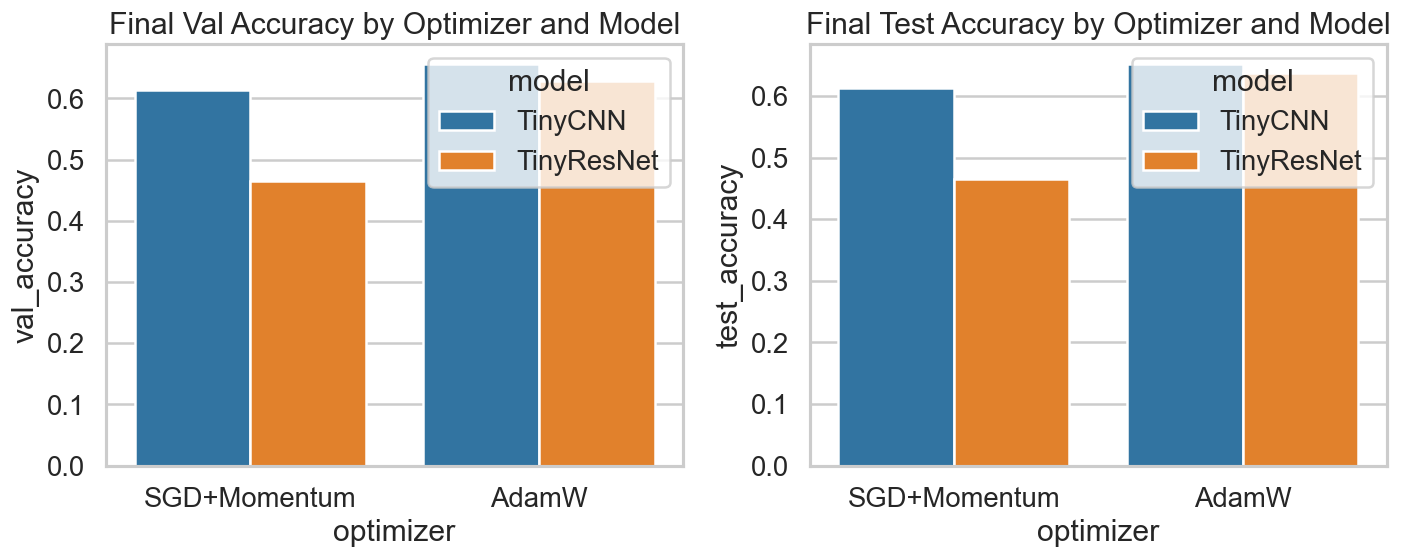

Saved plots: reports/scaling_validation_v3/week5_plots/week5_val_accuracy_curves.png reports/scaling_validation_v3/week5_plots/week5_val_loss_curves.png reports/scaling_validation_v3/week5_plots/week5_final_metrics.png


In [ ]:
# --- Plots: accuracy/loss curves and final bars ---

# Accuracy/Loss curves per config
plt.figure(figsize=(10, 6))
for config_id, hist in histories.items():
	epochs = [h["epoch"] for h in hist]
	val_acc = [h["val_acc"] for h in hist]
	plt.plot(epochs, val_acc, marker="o", label=config_id)
plt.title("Validation Accuracy vs Epochs (Long Runs)")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
acc_path = PLOT_DIR / "week1-5_val_accuracy_curves.png"
plt.savefig(acc_path, dpi=160)
plt.show()

plt.figure(figsize=(10, 6))
for config_id, hist in histories.items():
	epochs = [h["epoch"] for h in hist]
	val_loss = [h["val_loss"] for h in hist]
	plt.plot(epochs, val_loss, marker="o", label=config_id)
plt.title("Validation Loss vs Epochs (Long Runs)")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
loss_path = PLOT_DIR / "week1-5_val_loss_curves.png"
plt.savefig(loss_path, dpi=160)
plt.show()

# Final metric bars
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=results_df, x="optimizer", y="val_accuracy", hue="model", ax=axes[0])
axes[0].set_title("Final Val Accuracy by Optimizer and Model")
sns.barplot(data=results_df, x="optimizer", y="test_accuracy", hue="model", ax=axes[1])
axes[1].set_title("Final Test Accuracy by Optimizer and Model")
plt.tight_layout()
bar_path = PLOT_DIR / "week1-5_final_metrics.png"
plt.savefig(bar_path, dpi=160)
plt.show()

print("Saved plots:", acc_path, loss_path, bar_path)


### Weekly Workflow Template

- Duplicate this notebook for Week 6 (e.g., `week6_research.ipynb`).
- Update `max_epochs`, dataset size, and add any new optimizers/schedules.
- Keep exporting plots to `reports/scaling_validation_v3/week{N}_plots/` for consistent Notion uploads.
- Optional: append results to a master CSV for longitudinal tracking.
